In [47]:
import os
from datetime import date, timedelta
from netCDF4 import Dataset,date2num,num2date
import numpy as np
import numpy.ma as ma
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import pearsonr
from AOSproject import Heidke_Skill
from AOSproject import NRMSE
from AOSproject import motion_Vector_Cal
import scipy.interpolate

In [4]:
dstage =xr.open_dataset("D:\!WISC_Res\STREAM\data\STAGEIV2018_0.1deg.3_10.hourly.nc")
dstage  # 0.1 deg

<xarray.Dataset>
Dimensions:    (time: 5880, lat: 100, lon: 150)
Coordinates:
  * time       (time) datetime64[ns] 2018-03-01 ... 2018-10-31T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float64 ...
    longitude  (lon) float64 ...
    prcp       (lat, lon, time) float64 ...

In [7]:
StageH=dstage['prcp']

xsizeF=np.shape(StageH)[1]
ysizeF=np.shape(StageH)[0]
tsizeF=np.shape(StageH)[2]

start='2018-05-01T20:00:00'
endt='2018-05-01T21:00:00'
dt=1 #hr
StageH1=StageH.sel(time=start)

In [9]:
dsmerra= xr.open_dataset("D:\\22FallCourse\AOS_PROJ\MERRA2_0.1.2018.5_9.hourly.nc")
TQV= dsmerra['TQV']
dsmerra  #0.5 deg 0.625 deg

<xarray.Dataset>
Dimensions:    (time: 3672, lat: 21, lon: 25)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-01 ... 2018-09-30T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float64 ...
    longitude  (lon) float64 ...
    U850       (time, lat, lon) float32 ...
    V850       (time, lat, lon) float32 ...
    TQV        (time, lat, lon) float32 ...

In [13]:
w=5
TQV1=TQV.sel(time=start)
TQV2=TQV.sel(time=endt)

T1,T2= motion_Vector_Cal(TQV1.data,TQV2.data,w) #V,U

Notes: this step may need 20 seconds, I appreciate you patience on this!

Dowanscale the motion vector calculated from MERRA2-TQV to 0.1 deg. Note that the unit of T2 and T1 is number of grid. Scaling is needed when downscaling

In [17]:
# V850 U850 T1 T2
dsmerra['lon']=dsmerra['longitude']
dsmerra['lat']=dsmerra['latitude']

xsize=np.shape(T1)[1]
ysize=np.shape(T1)[0]
factory=ysizeF/ysize
factorx=xsizeF/xsize

dsmerra['TQV_U']=xr.DataArray(T2*factorx,dims=['lat','lon'])  #U east ward
dsmerra['TQV_V']=xr.DataArray(T1*factory,dims=['lat','lon'])   #V southward

dsmerra_re=dsmerra.interp(lat=dstage['latitude'],lon=dstage['longitude'])

dsmerra_re

<xarray.Dataset>
Dimensions:    (time: 3672, lat: 100, lon: 150)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-01 ... 2018-09-30T23:00:00
  * lat        (lat) float64 44.95 44.85 44.75 44.65 ... 35.35 35.25 35.15 35.05
  * lon        (lon) float64 -99.95 -99.85 -99.75 ... -85.25 -85.15 -85.05
Data variables:
    latitude   (lat) float64 44.95 44.85 44.75 44.65 ... 35.35 35.25 35.15 35.05
    longitude  (lon) float64 -99.95 -99.85 -99.75 ... -85.25 -85.15 -85.05
    U850       (time, lat, lon) float64 3.519 3.17 2.821 ... -2.389 -2.412
    V850       (time, lat, lon) float64 -9.551 -8.916 -8.281 ... 4.063 4.147
    TQV        (time, lat, lon) float64 25.19 25.28 25.38 ... 36.66 36.59 36.52
    TQV_U      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TQV_V      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

I propogate precipitation using the calculated motion vetor from MERRA-2-TQV

In [19]:
yind=np.repeat(np.arange(0,ysizeF),xsizeF).reshape(ysizeF,xsizeF).astype('int16')
xind=np.tile(np.arange(0,xsizeF),ysizeF).reshape(ysizeF,xsizeF).astype('int16')

# propogation using TQV
yafter=np.array((yind-dsmerra_re['TQV_V'].data)%ysizeF,dtype='int16')
xafter=np.array((xind-dsmerra_re['TQV_U'].data)%xsizeF,dtype='int16')

newprcpTQV=StageH1.data[yafter,xafter]

Again, using U850 and V850 in MERRA-2 to propogate the precipitation
Note that Precipitation data StageIV is hourly and 0.1 deg data. The unit of U850, V850 is m/s. The unit of calculted motion vector is number of grid.

In [26]:
R=6371000
deltaU=dsmerra_re['U850'].sel(time=start)*60*60*dt // (np.cos(dsmerra_re['latitude']/180*np.pi)*R*0.1/180*np.pi)  # distance with unit m
deltaV=-dsmerra_re['V850'].sel(time=start)*60*60*dt // (R*0.1/180*np.pi)  # distance with unit m  
# note deltaV here is southward

In [32]:
yafter=np.array((yind-deltaV)%ysizeF,dtype='int16')
xafter=np.array((xind-deltaU)%xsizeF,dtype='int16')

newprcp850=StageH1.data[yafter,xafter]

I draw the two types of motion vection

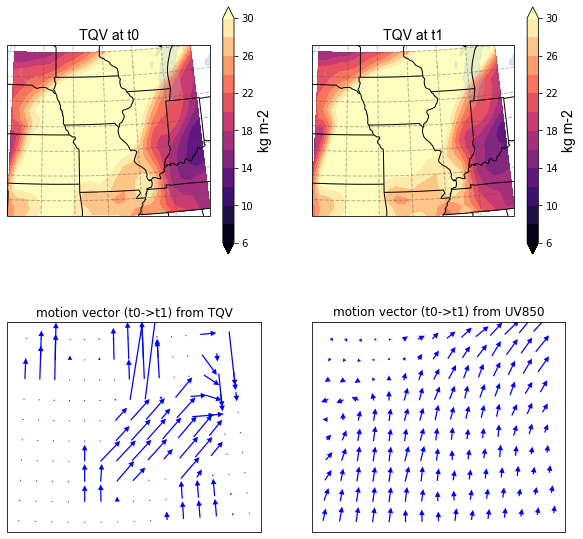

In [33]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig,ax=plt.subplots(2,2,subplot_kw={'projection':ccrs.LambertConformal()},figsize=(10,10))
axs=ax.flatten()
plt.sca(axs[0])
cs=axs[0].contourf(dsmerra.longitude,dsmerra.latitude,TQV1,
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),levels=range(6,32,2),extend='both')
axs[0].set_title('TQV at t0',font='arial',fontsize=14)

plt.sca(axs[1])
cs=axs[1].contourf(dsmerra.longitude,dsmerra.latitude,TQV2,
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),levels=range(6,32,2),extend='both')
axs[1].set_title('TQV at t1',font='arial',fontsize=14)

axs[2].quiver(dsmerra_re.longitude[::10],dsmerra_re.latitude[::10],dsmerra_re['TQV_U'][::10,::10].data,
              -dsmerra_re['TQV_V'][::10,::10].data,
          transform=ccrs.PlateCarree(),color='blue',headwidth=4.5,headlength=4.5)
axs[2].set_title('motion vector (t0->t1) from TQV')

axs[3].quiver(dsmerra_re.longitude[::10],dsmerra_re.latitude[::10],deltaU[::10,::10].data,-deltaV[::10,::10].data,
          transform=ccrs.PlateCarree(),color='blue',headwidth=4.5,headlength=4.5)
axs[3].set_title('motion vector (t0->t1) from UV850')

for i in range(0,2):
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    
    axs[i].set_extent([-100,-85,45, 35],ccrs.PlateCarree())
    axs[i].add_feature(cfeature.LAKES, alpha=0.2)
    axs[i].add_feature(states_provinces, edgecolor='black')

    gl = axs[i].gridlines(color='0.3',alpha=0.4,linewidth=1,linestyle='--') #
    cbar=plt.colorbar(cs,ax=axs[i],orientation='vertical')
    cbar.set_label('kg m-2',font='arial',fontsize=14)

In [34]:
dsmerra_re['U850shift']=xr.DataArray(deltaU,dims=['lat','lon'])
dsmerra_re['V850shift']=xr.DataArray(deltaV,dims=['lat','lon'])
dsmerra_re['newprcp850']=xr.DataArray(newprcp850,dims=['lat','lon'])
dsmerra_re['newprcpTQV']=xr.DataArray(newprcpTQV,dims=['lat','lon'])

I draw the propogated precipitation 

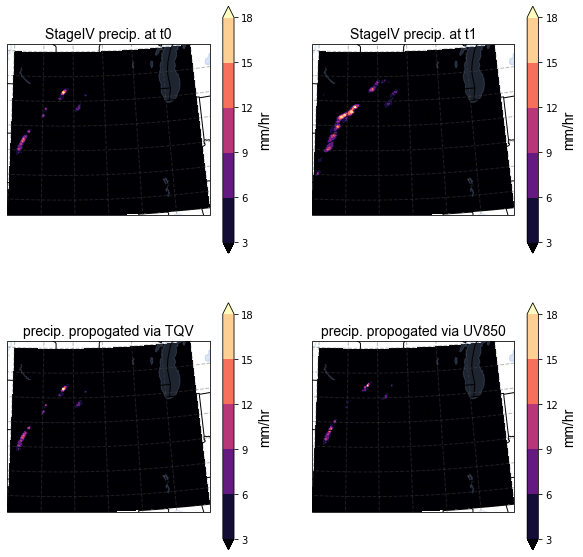

In [35]:
levels=range(6,32,2)

fig,ax=plt.subplots(2,2,subplot_kw={'projection':ccrs.LambertConformal()},figsize=(10,10))
axs=ax.flatten()
plt.sca(axs[0])
cs=axs[0].contourf(dstage.longitude,dstage.latitude,StageH.sel(time=start),
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),extend='both')
axs[0].set_title('StageIV precip. at t0',font='arial',fontsize=14)

plt.sca(axs[1])
cs=axs[1].contourf(dstage.longitude,dstage.latitude,StageH.sel(time=endt),
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),extend='both')
axs[1].set_title('StageIV precip. at t1',font='arial',fontsize=14)

plt.sca(axs[2])
cs=axs[2].contourf(dstage.longitude,dstage.latitude,dsmerra_re['newprcpTQV'],
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),extend='both')
axs[2].set_title('precip. propogated via TQV',font='arial',fontsize=14)

plt.sca(axs[3])
cs=axs[3].contourf(dstage.longitude,dstage.latitude,dsmerra_re['newprcp850'],
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),extend='both')
axs[3].set_title('precip. propogated via UV850',font='arial',fontsize=14)

for i in range(0,4):
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    
    axs[i].set_extent([-100,-85,45, 35],ccrs.PlateCarree())
    axs[i].add_feature(cfeature.LAKES, alpha=0.2)
    axs[i].add_feature(states_provinces, edgecolor='black')

    gl = axs[i].gridlines(color='0.3',alpha=0.4,linewidth=1,linestyle='--') #
    cbar=plt.colorbar(cs,ax=axs[i],orientation='vertical')
    cbar.set_label('mm/hr',font='arial',fontsize=14)


I use pearsonR, Heidke_Skill,NRMSE to evaluate the propogated precipitation and the real precipitation. A higher pearsonR and Heidke_Skill, a lower NRMSE 

In [38]:
realPrcp=StageH.sel(time=endt).data

R_TQV=pearsonr(newprcpTQV.flatten(), realPrcp.flatten())[0]
HS_TQV=Heidke_Skill(realprcp,newprcpTQV)
NRMSE_TQV=NRMSE(realprcp,newprcpTQV)

R_850=pearsonr(newprcp850.flatten(), realPrcp.flatten())[0]
HS_850=Heidke_Skill(realprcp,newprcp850)
NRMSE_850=NRMSE(realprcp,newprcp850)

print('propogated precipitation from TQV:')
print("pearson R=%0.02f"%(R_TQV))
print("Heidke_Skill=%0.02f"%(HS_TQV))
print("NRMSE=%0.02f"%(NRMSE_TQV))

print('propogated precipitation from UV850:')
print("pearson R=%0.02f"%(R_850))
print("Heidke_Skill=%0.02f"%(HS_850))
print("NRMSE=%0.02f"%(NRMSE_850))

propogated precipitation from TQV:
pearson R=0.19
Heidke_Skill=0.38
NRMSE=7.38
propogated precipitation from UV850:
pearson R=0.08
Heidke_Skill=0.34
NRMSE=7.60


Look back to the precipitation data, I calculate motion vector just based on the Stage IV observations, and make a comparison with aboved precipitation field.

In [40]:
Stage12=StageH.sel(time=slice(start,endt))

Stage12['lon']=dstage['longitude']  
Stage12['lat']=dstage['latitude'] 

# to reduce the computation load, I upscale the stageIV 
Stage12_down=Stage12.interp(lat=np.arange(44.95,35.05,-0.5),lon=np.arange(-99.95,-85.05,0.5))

In [48]:
w=5
TS1,TS2= motion_Vector_Cal(Stage12_down.data[:,:,0],Stage12_down.data[:,:,1],w) #V,U

D:\anoconda\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [49]:
xsize=np.shape(TS1)[1]
ysize=np.shape(TS1)[0]
factory=ysizeF/ysize
factorx=xsizeF/xsize
# here I use cv package to downscale
TS_v = cv2.resize(TS1*factory, (xsizeF,ysizeF), interpolation = cv2.INTER_LINEAR) 
TS_u= cv2.resize(TS2*factorx, (xsizeF,ysizeF), interpolation = cv2.INTER_LINEAR) 
dsmerra_re['Stage_U']=xr.DataArray(TS_u,dims=['lat','lon'])
dsmerra_re['Stage_V']=xr.DataArray(TS_v,dims=['lat','lon'])

In [45]:
TS_u

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0.5, 1.0, 'Meridional mean MV')

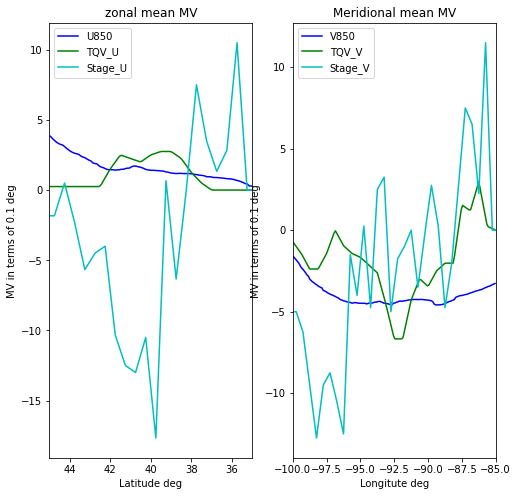

In [50]:
# accuracy at magnitude and speed in both the longitudinal and latitudinal directions.
# meridional gradient of the zonal mean temperature
U850_zn=dsmerra_re['U850shift'].mean(dim='lon')
V850_me=dsmerra_re['V850shift'].mean(dim='lat')

TQV_U_zn=dsmerra_re['TQV_U'].mean(dim='lon')
TQV_V_me=dsmerra_re['TQV_V'].mean(dim='lat')

StageU_zn=dsmerra_re['Stage_U'].mean(dim='lon')
StageV_me=dsmerra_re['Stage_V'].mean(dim='lat')

fig,ax=plt.subplots(1,2,figsize=(8,8))
ax[0].plot(dsmerra_re['lat'],U850_zn.data,c='blue',label='U850')
ax[0].plot(dsmerra_re['lat'],TQV_U_zn.data,c='green',label='TQV_U')
ax[0].plot(dsmerra_re['lat'],StageU_zn.data,c='c',label='Stage_U')

ax[0].legend()
ax[0].set_xlim(45,35)
ax[0].set_xlabel('Latitude deg')
ax[0].set_ylabel('MV in terms of 0.1 deg')
ax[0].set_title('zonal mean MV')

ax[1].plot(dsmerra_re['lon'],V850_me.data,c='blue',label='V850')
ax[1].plot(dsmerra_re['lon'],TQV_V_me.data,c='green',label='TQV_V')
ax[1].plot(dsmerra_re['lon'],StageV_me.data,c='c',label='Stage_V')

ax[1].legend()
ax[1].set_xlim(-100,-85)
ax[1].set_xlabel('Longitute deg')
ax[1].set_ylabel('MV in terms of 0.1 deg')
ax[1].set_title('Meridional mean MV')
